In [3]:
import qiskit as qk
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
from qiskit.visualization import plot_histogram
from math import pi
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd
import numpy as np
import random
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from time import time
from qiskit.circuit.library.standard_gates import RYGate, RYYGate

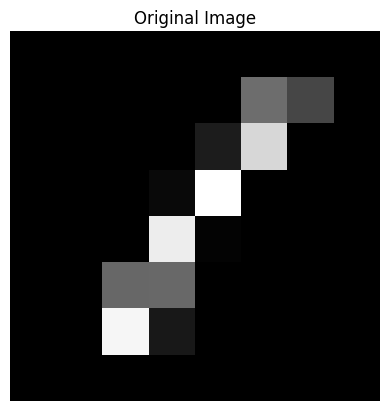

In [4]:
# Read the CSV file. 
# (Assuming the CSV has a label in the first column and pixel values in the remaining 64 columns, for an 8x8 image.)
dataset = pd.read_csv('mnist-resized neqr.csv')

# Select the first image, ignoring the label column.
# Adjust slicing if your file has a different format.
image_data = dataset.to_numpy()[0, 1:]
# Reshape to an 8x8 array and ensure pixel values are integers (0-255)
image = image_data.reshape(8, 8).astype(np.uint8)

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
# Normalize pixel values to 8-bit integers (0-255)
pixel_values = image.flatten()

# Declare the Quantum and Classical registers
position_qubits = QuantumRegister(6, 'pos')  # 6 qubits for 64 positions
intensity_qubits = QuantumRegister(8, 'int')  # 8 qubits for intensity (8-bit grayscale)
classical_bits = ClassicalRegister(14, 'c')  # For measurement
qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)

# Function to apply Hadamard gates to position qubits
def hadamard(circ, n):
    for i in n:
        circ.h(i)

def encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_values):
    num_position_qubits = len(position_qubits)
    num_intensity_qubits = len(intensity_qubits)
    
    for idx, pixel in enumerate(pixel_values):
        # Convert index to binary (with leading zeros)
        bin_idx = format(idx, f'0{num_position_qubits}b')
        
        # Step 1: Apply X gates to "select" the current position
        x_qubits = [
            position_qubits[i] 
            for i, bit in enumerate(bin_idx) 
            if bit == '0'
        ]
        # Apply X gates one by one
        for q in x_qubits:
            circ.x(q)
        
        # Step 2: Encode intensity (binary value of the pixel)
        intensity_bin = format(pixel, f'0{num_intensity_qubits}b')
        for i, bit in enumerate(intensity_bin):
            if bit == '1':
                # Apply multi-controlled X gate (controls=position_qubits, target=intensity_qubits[i])
                circ.mcx(
                    control_qubits=position_qubits, 
                    target_qubit=intensity_qubits[i]
                )
        
        # Step 3: Uncompute X gates to reset position qubits
        for q in x_qubits:
            circ.x(q)


# NEQR function to encode the image
def neqr(circ, position_qubits, intensity_qubits, pixel_values):
    # Apply Hadamard to position qubits to create superposition
    circ.h(position_qubits)
    # Encode pixel values
    encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_values)


# Apply NEQR encoding
neqr(qc, position_qubits, intensity_qubits, pixel_values)

# Measure all qubits
qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

# Visualize the circuit
qc.draw('mpl')

CircuitError: 'One or more of the arguments are empty'

In [ ]:
# Simulate the circuit
simulator = AerSimulator()
t_qc = qk.transpile(qc, simulator)
result = simulator.run(t_qc, shots=10000).result()
counts = result.get_counts()

# Plot the histogram of results
plot_histogram(counts, title="Measurement Outcomes", bar_labels=True, color="blue")
plt.show()

# Print the counts dictionary
print("Counts from simulation:")
for key, value in counts.items():
    print(f"{key}: {value}")

    

Simplified counts: {'00000000101110': 183, '00000000110010': 138, '00000000000101': 152, '00000000011001': 161, '00000000101000': 154, '00000000100000': 157, '00000000001000': 161, '00000000010110': 161, '00000000000011': 152, '10010000110110': 148, '00000000110100': 161, '00000000011110': 136, '00000000011010': 170, '00011000110011': 164, '00000000110000': 170, '01100110110101': 168, '10100110010101': 176, '00000000000111': 160, '00000000111010': 151, '10010111110001': 147, '00000000001111': 141, '00000000100110': 150, '00000000101101': 165, '00000000000100': 145, '11011111001110': 160, '00000000111110': 156, '00000000100010': 156, '00000000001011': 170, '00000000100101': 159, '00000000111011': 150, '00000000000000': 147, '00000000110111': 171, '00000000111101': 155, '00000000100011': 169, '00000000001100': 162, '00000000011101': 142, '00000000111000': 152, '11001011101010': 150, '00000000010010': 144, '00000000101011': 172, '00000000000010': 184, '00000000000110': 166, '0000000010111

Position 0 (binary 000000): Intensity binary 11111111, Intensity value 255
Position 1 (binary 000001): Intensity binary 00000000, Intensity value 0
Position 2 (binary 000010): Intensity binary 00000000, Intensity value 0
Position 3 (binary 000011): Intensity binary 00000000, Intensity value 0
Position 4 (binary 000100): Intensity binary 00000000, Intensity value 0
Position 5 (binary 000101): Intensity binary 00000000, Intensity value 0
Position 6 (binary 000110): Intensity binary 00000000, Intensity value 0
Position 7 (binary 000111): Intensity binary 00000000, Intensity value 0
Position 8 (binary 001000): Intensity binary 00000000, Intensity value 0
Position 9 (binary 001001): Intensity binary 00000000, Intensity value 0
Position 10 (binary 001010): Intensity binary 00000000, Intensity value 0
Position 11 (binary 001011): Intensity binary 00000000, Intensity value 0
Position 12 (binary 001100): Intensity binary 00000000, Intensity value 0
Position 13 (binary 001101): Intensity binary 

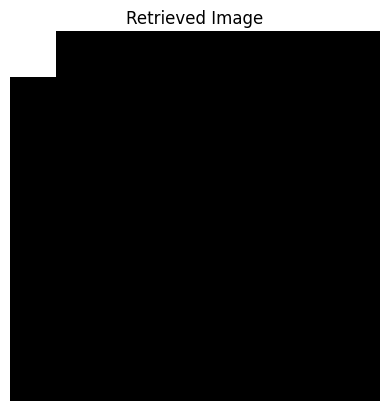

In [21]:
# Retrieve the image from the measurement results
retrieve_image = np.zeros(64)
for i in range(64):
    position_binary = f"{i:06b}"
    intensity_binary = ""
    for j in range(8):
        key = position_binary + f"{j:08b}"
        if key in counts:
            intensity_binary += "1"
        else:
            intensity_binary += "0"
    intensity_value = int(intensity_binary, 2)
    print(f"Position {i} (binary {position_binary}): Intensity binary {intensity_binary}, Intensity value {intensity_value}")
    retrieve_image[i] = intensity_value

# Reshape the retrieved image to 8x8
retrieve_image = retrieve_image.reshape((8, 8))

# Plot the retrieved image
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.title("Retrieved Image")
plt.axis('off')
plt.show()